## Problem 1: Visualise data in a static map (10 points)


Create a *static* **thematic map** using the skills you learnt during lesson 5. The map should <br>
contain more than one layer (from at least two different data sets). Pay attention to classification <br>
and visualisation (appropriate colour scheme choice, etc.). Write your code in this notebook, and <br>
store the resulting maps in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder.

### Topic of the map

- Use any of the data sets we have used during the course (travel time data, population grid), or <br>
  any other data set of your interest (for example, [open data sets from Statistics Finland](https://www.stat.fi/org/avoindata/index_en.html), <br>
  or the open geo-data from [the Helsinki Region Infoshare](https://hri.fi/en)). If you download <br>
  data sets, add, commit, and push them to the `DATA_DIRECTORY`. Be sure to include an attribution <br>
  to each data set in your output map!
- Feel free to start from and adapt examples from the course material! You can take one step further <br>
  and add additional analysis to, e.g., the shopping centre dominance or the population within vincinity <br>
  of certain addresses)

### Criteria

- The map has more than one data layer (for instance, the results of an analysis, and the road network <br>
  to illustrate a complex spatial pattern). If (and only if) you think it adds additional value, feel <br>
  free to add a base map (but a base map does not count as an own layer) (2 points)
- The map portrays the output of an analysis or a classification that adds value beyond just displaying <br>
  the raw data (3 points)
- The map follows good cartographic practices (appropriate map extent and zoom level, colour scheme, <br>
  legend and data sources, etc.) (5 points)

### Output

- Save the map(s) in `.png` format in the `NOTEBOOK_DIRECTORY / "docs"` folder, remember to add, commit, <br>
  and push them to the GitHub repository
- Remember to also add, commit, and push input data sets and code

---

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "static" / "docs"

In [3]:
# I'm going to start with the addresses and geocode them
import pandas
addresses = pandas.read_csv(
    DATA_DIRECTORY / "helsinki_addresses" / "addresses.txt",
    sep=";"
)

addresses.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [4]:
# geocode the addresses
import geopandas

geocoded_addresses = geopandas.tools.geocode(
    addresses["addr"],
    provider="nominatim",
    user_agent="autogis2023",
    timeout=10
)
geocoded_addresses.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp..."
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust..."
3,POINT (24.97840 60.18934),"Hermannin rantatie, Verkkosaari, Kalasatama, S..."
4,POINT (24.92169 60.15667),"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E..."


In [6]:
geocoded_addresses.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
import geopandas
import numpy
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load the accessibility grid and remove -1 values
accessibility_grid = geopandas.read_file(
    DATA_DIRECTORY
    / "helsinki_region_travel_times_to_railway_station"
    / "helsinki_region_travel_times_to_railway_station.gpkg"
)
accessibility_grid["walk_t"] = accessibility_grid["walk_t"].replace(-1, numpy.nan)

# Construct the base URL to retrive the Helsinki Metro data
WFS_BASE_URL = (
    "https://kartta.hel.fi/ws/geoserver/avoindata/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&srsName=EPSG:3879"
    "&typeName={layer:s}"
)

# Read the metro/road data and apply the CRS
metro = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_metro_rata")
    )
    .set_crs("EPSG:3879")
)
roads = (
    geopandas.read_file(
        WFS_BASE_URL.format(layer="avoindata:Seutukartta_liikenne_paatiet")
    )
    .set_crs("EPSG:3879")
)

In [29]:
# Check the CRS
assert accessibility_grid.crs == metro.crs == roads.crs, "Input data sets’ CRS differs"

AssertionError: Input data sets’ CRS differs

In [30]:
# Convert the metro CRS to the accessibility CRS
roads = roads.to_crs(accessibility_grid.crs)
metro = metro.to_crs(accessibility_grid.crs)
geocoded_addresses = geocoded_addresses.to_crs(accessibility_grid.crs)

In [31]:
# Check the CRS
assert accessibility_grid.crs == metro.crs == roads.crs, "Input data sets’ CRS differs"

(6665250.00004393, 6698000.000038021)

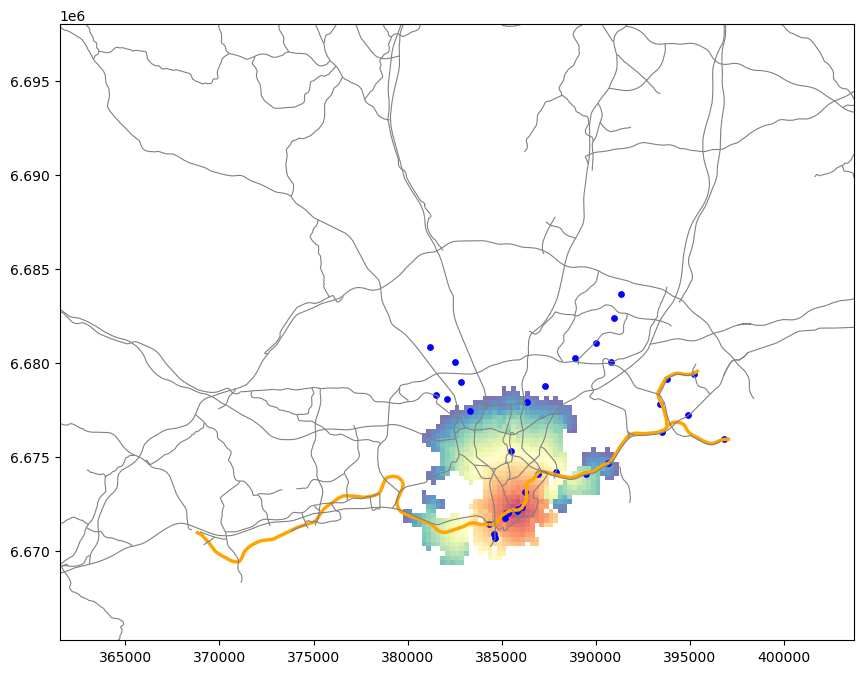

In [34]:
within_100 = accessibility_grid[accessibility_grid["walk_t"] <= 100]
# Plot the public transport times by quantile
ax = within_100.plot(
    figsize=(12, 8),

    column="walk_t",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8
)

# Add the metro lines
metro.plot(
    ax=ax,
    color="orange",
    linewidth=2.5
)

# Add the roads
roads.plot(
    ax=ax,
    color="grey",
    linewidth=0.8
)

# add the addresses
geocoded_addresses.plot(
  ax=ax,
  color="blue",
  markersize=15
)

# Set the map bounds
minx, miny, maxx, maxy = accessibility_grid.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)